# Stock Performance Tracker


## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")

user_name_l = ["ta", "tl"]
user_combined = "user_combined"
user_name_combined_l = user_name_l + [user_combined]

index_combined = "index_combined"
index_name_l = ["vni", "vn30"]
index_name_combined_l = index_name_l + [index_combined]


## Read data


### Log table


In [3]:
log_df = pd.read_csv("./stock_data - log.csv", index_col="date", parse_dates=True)
log_df = log_df.sort_index()  # type: ignore
log_df.tail()


,ta,tl,vni,vn30
date,,,,
2022-01-24,167416073,400128653,1439.71,1471.31
2022-01-25,169543555,405165142,1479.58,1516.16
2022-01-26,173345446,414219519,1481.58,1525.31
2022-01-27,172484480,411899443,1470.76,1516.57
2022-01-28,173094888,412223583,1478.96,1532.24


In [4]:
assert log_df.index.inferred_type == "datetime64"
log_df.dtypes


ta        int64
tl        int64
vni     float64
vn30    float64
dtype: object

### Cashflow


In [5]:
ta_cf_df = pd.read_csv(
    "./stock_data - ta_cashflow.csv",
    index_col="date",
    parse_dates=True,
)
tl_cf_df = pd.read_csv(
    "./stock_data - tl_cashflow.csv",
    index_col="date",
    parse_dates=True,
)
cf_df = pd.concat([ta_cf_df, tl_cf_df], axis=1)  # type: ignore
assert cf_df.index.inferred_type == "datetime64"
cf_df.fillna(0, inplace=True)
cf_df


,ta_cashflow,tl_cashflow
date,,
2020-12-29,-1000000.0,0.0
2020-12-30,-4000000.0,0.0
2020-12-31,-20000000.0,0.0
2021-01-05,-1100000.0,0.0
2021-01-08,14000000.0,0.0
2021-01-29,-2500000.0,0.0
2021-02-01,-5300000.0,0.0
2021-02-22,-7900000.0,0.0
2021-03-15,-25000000.0,0.0


## [Chart] NAV


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_8778/2300920108.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))


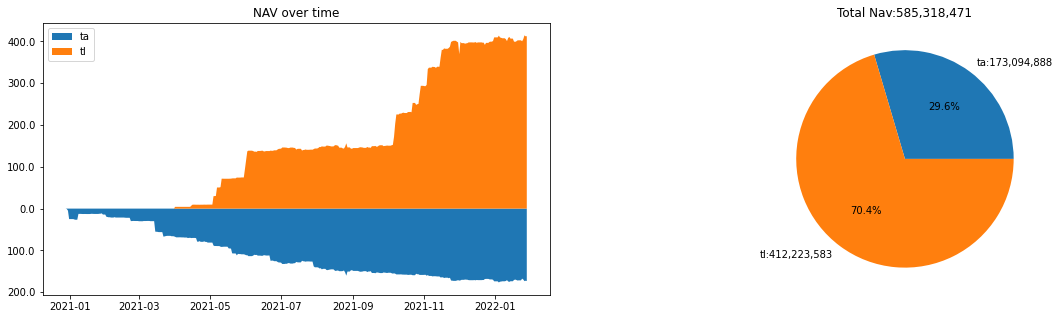

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2)  # type: ignore


# Line plot
for i, user_name in enumerate(user_name_l):
    sign = -1 if i % 2 == 0 else 1
    ax1.fill_between(log_df.index, sign * log_df[user_name], label=user_name)

# set labels to absolute values
ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))

ax1.set_title("NAV over time")
ax1.legend(loc="upper left")

# Pie chart
nav_l = [log_df[user_name].iloc[-1] for user_name in user_name_l]  # type: ignore
label_l = [f"{user_name}:{nav:,}" for user_name, nav in zip(user_name_l, nav_l)]
ax2.pie(nav_l, labels=label_l, autopct="%1.1f%%")

ax2.set_title(f"Total Nav:{np.sum(nav_l):,}")


plt.show()


## [Chart] Index over time


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_8778/1838202483.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(log_df.index, log_df["vni"], label="vni", linestyle="-", marker=None)
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_8778/1838202483.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(log_df.index, log_df["vn30"], label="vn30", linestyle="-", marker=None)


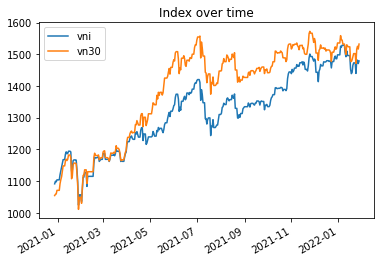

In [7]:
plt.plot_date(log_df.index, log_df["vni"], label="vni", linestyle="-", marker=None)
plt.plot_date(log_df.index, log_df["vn30"], label="vn30", linestyle="-", marker=None)

plt.title("Index over time")

plt.gcf().autofmt_xdate()
plt.legend()

plt.show()


## [Process] Processing


### Adding diff columns


In [8]:
for name in user_name_l + index_name_l:
    log_df[f"{name}_diff"] = log_df[name].diff()
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-4152078.0,-2217055.0,-33.18,-30.85
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,610408.0,324140.0,8.20,15.67


### Remove unchanged dates from `log_df`


In [9]:
unchanged_filt = log_df[f"{user_name_l[0]}_diff"] == 0
log_df = log_df.loc[~unchanged_filt]
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-4152078.0,-2217055.0,-33.18,-30.85
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,610408.0,324140.0,8.20,15.67


### Compensating diff with cashflow


In [10]:
for user_name in user_name_l:
    log_df[f"{user_name}_diff"] = log_df[f"{user_name}_diff"].add(
        cf_df[f"{user_name}_cashflow"], fill_value=0
    )
log_df.tail()

,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67


### Adding Combined columns


In [11]:
# Diff for user
diff_user_column_name_l = [f"{user_name}_diff" for user_name in user_name_l]

log_df[user_combined] = log_df[user_name_l].sum(axis=1)
log_df[f"{user_combined}_diff"] = log_df[diff_user_column_name_l].sum(axis=1)

# Diff for index
diff_index_column_name_l = [f"{index_name}_diff" for index_name in index_name_l]

log_df[index_combined] = log_df[index_name_l].mean(axis=1)
log_df[f"{index_combined}_diff"] = log_df[diff_index_column_name_l].mean(axis=1)

log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff
date,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935


### Calculating diff percent & aux diff percent


In [29]:
for user_name in user_name_combined_l + index_name_combined_l:

    log_df[f"{user_name}_diff_p"] = (
        log_df[f"{user_name}_diff"] / log_df[user_name].shift()
    )

    # Replace inf values with nan in diff_p (otherwise, growth would be infinite)
    log_df[f"{user_name}_diff_p"] = log_df[f"{user_name}_diff_p"].replace(
        [np.inf, -np.inf], np.nan
    )

    log_df[f"{user_name}_aux_diff_p"] = log_df[f"{user_name}_diff_p"] + 1

# for index_name in index_name_combined_l:
#     log_df[f"{index_name}_diff_p"] = (
#         log_df[f"{index_name}_diff"] / log_df[index_name].shift()
#     )

log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vn30_diff_p,index_combined_diff_p,Y,Q,M,vni_aux_diff_p,vn30_aux_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015,-0.005409,0.994591,-0.005510,0.994490,-0.005480,0.994520,-0.022527,-0.020537,-0.021522,2022,2022Q1,2022-01,0.977473,0.979463,0.978478
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360,0.012708,1.012708,0.012587,1.012587,0.012623,1.012623,0.027693,0.030483,0.029103,2022,2022Q1,2022-01,1.027693,1.030483,1.029103
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,0.006035,0.003722,2022,2022Q1,2022-01,1.001352,1.006035,1.003722
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,-0.005730,-0.006505,2022,2022Q1,2022-01,0.992697,0.994270,0.993495
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,0.010333,0.007990,2022,2022Q1,2022-01,1.005575,1.010333,1.007990


## [Chart] Diff percent


### Histogram

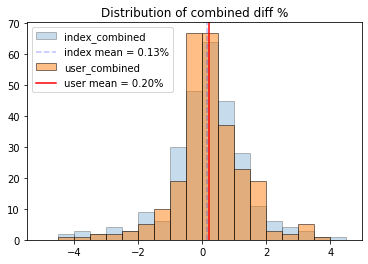

In [13]:
bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
plt.hist(
    log_df[f"{index_combined}_diff_p"] * 100,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=index_combined,
)
index_diff_p_mean = log_df[f"{index_combined}_diff_p"].mean() * 100  # type: ignore

plt.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# User histogram
plt.hist(
    log_df[f"{user_combined}_diff_p"] * 100,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=user_combined,
)
user_diff_p_mean = log_df[f"{user_combined}_diff_p"].mean() * 100  # type: ignore
plt.axvline(
    user_diff_p_mean,
    color="red",
    label="user mean = %.2f%%" % user_diff_p_mean,
)


plt.title("Distribution of combined diff %")
plt.legend()
plt.show()


### Scatter plot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


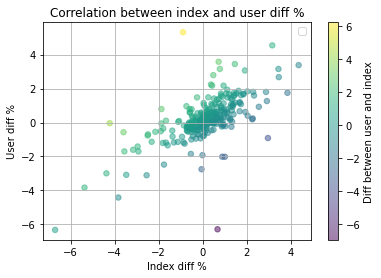

In [14]:
index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
user_diff_p_l = log_df[f"{user_combined}_diff_p"] * 100
plt.scatter(
    index_diff_p_l,
    user_diff_p_l,
    c=user_diff_p_l - index_diff_p_l,  # type: ignore
    s=30,
    alpha=0.5,
)

cbar = plt.colorbar()
cbar.set_label("Diff between user and index")

plt.title("Correlation between index and user diff %")
plt.xlabel("Index diff %")
plt.ylabel("User diff %")

plt.legend()
plt.grid(True)
plt.show()


## [Chart] Growth


In [15]:
def get_overall_growth_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    log_df = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=log_df.index)
    for user_name in user_name_combined_l:
        # set first date aux_diff_p to 1
        log_df[f"{user_name}_aux_diff_p"].iloc[0] = 1  # type: ignore
        # calculate growth using cumulative product since anchor date
        df[user_name] = log_df[f"{user_name}_aux_diff_p"].cumprod()
    for index_name in index_name_combined_l:
        # calculate growth using proportion since anchor date
        df[index_name] = log_df[f"{index_name}"] / log_df[f"{index_name}"].iloc[0]  # type: ignore
    return df.fillna(1)  # type: ignore


### Growth time series


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_8778/3599096511.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df[f"{user_name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_8778/3599096511.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df[f"{user_name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_8778/3599096511.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

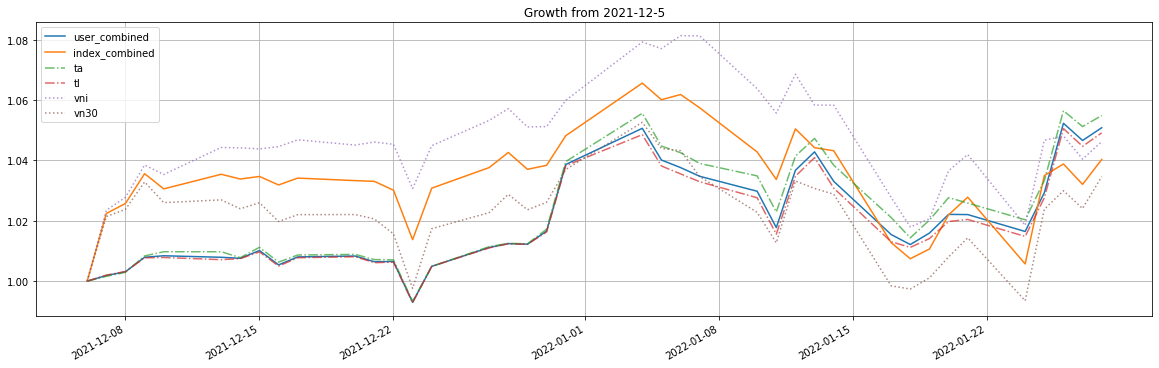

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))

anchor_date = "2021-12-5"
growth_df = get_overall_growth_df(log_df, anchor_date=anchor_date)

for combined_name in [user_combined, index_combined]:
    ax.plot_date(
        growth_df.index,
        growth_df[combined_name],
        linestyle="-",
        marker=None,
        label=combined_name,
    )

for single_name in user_name_l:
    ax.plot_date(
        growth_df.index,
        growth_df[single_name],
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax.plot_date(
        growth_df.index,
        growth_df[single_name],
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax.set_title(f"Growth from {anchor_date}")
ax.legend()
ax.grid(True)
fig.autofmt_xdate()


plt.show()


## [Process] Add period info


In [17]:
log_df["Y"] = log_df.index.to_period("Y")  # type: ignore
log_df["Q"] = log_df.index.to_period("Q")  # type: ignore
log_df["M"] = log_df.index.to_period("M")  # type: ignore
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vn30_diff_p,index_combined_diff_p,Y,Q,M
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015,-0.005409,0.994591,-0.005510,0.994490,-0.005480,0.994520,-0.022527,-0.020537,-0.021522,2022,2022Q1,2022-01
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360,0.012708,1.012708,0.012587,1.012587,0.012623,1.012623,0.027693,0.030483,0.029103,2022,2022Q1,2022-01
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,0.006035,0.003722,2022,2022Q1,2022-01
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,-0.005730,-0.006505,2022,2022Q1,2022-01
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,0.010333,0.007990,2022,2022Q1,2022-01


In [27]:
def get_period_df(period_symbol, log_df):
    period_l = log_df[period_symbol].unique()

    data = []
    for period in period_l:
        period_data_dict = {"period": period}
        period_filt = log_df[period_symbol] == period
        period_df = log_df.loc[period_filt]

        for user_name in user_name_combined_l:
            period_growth = period_df[f"{user_name}_aux_diff_p"].product()  # type: ignore
            period_data_dict[f"{user_name}_growth"] = period_growth - 1  # type: ignore

        for index_name in index_name_combined_l:
            index_growth = (period_df[index_name].iloc[-1] - period_df[index_name].iloc[0]) / period_df[index_name].iloc[  # type: ignore
                0
            ]
            period_data_dict[f"{index_name}_growth"] = index_growth

        data.append(period_data_dict)

    period_df = pd.DataFrame(data)
    period_df = period_df.set_index("period")
    period_df.index = period_df.index.to_series().astype(str)
    return period_df


## [Chart] Monthly


In [28]:
monthly_df = get_period_df("M", log_df)
monthly_df


,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth
period,,,,,,
2020-12,-0.012086,0.000000,-0.012086,0.011491,0.015689,0.013554
2021-01,-0.058015,0.000000,-0.058015,-0.056994,-0.039895,-0.048555
2021-02,0.119198,0.000000,0.119198,0.128400,0.139572,0.133971
2021-03,0.021305,0.000000,0.021305,0.004443,0.003700,0.004071
2021-04,0.097828,0.005679,0.092651,0.019151,0.070236,0.044799
2021-05,0.091439,0.118706,0.097430,0.069111,0.110502,0.090498
2021-06,0.057973,0.065138,0.061576,0.052901,0.031074,0.041426
2021-07,0.010179,0.004027,0.007063,-0.075529,-0.063366,-0.069185
2021-08,0.008648,-0.002645,0.002953,0.013126,-0.013499,-0.000833


In [20]:
def plot_growth(growth_df: pd.DataFrame, period_name: str):

    fig, ax = plt.subplots(figsize=(20, 6))

    # * Draw bar chart

    x_indices = np.arange(len(growth_df.index))

    bar_name_l = user_name_l + index_name_l
    bar_count = len(bar_name_l)
    total_width = 0.6
    bar_width = total_width / bar_count

    for i, name in enumerate(bar_name_l):
        position = x_indices + i * bar_width
        ax.bar(
            position,
            growth_df[f"{name}_growth"],
            label=name,
            width=bar_width,
        )

    # move back half bar width to left most edge and then move to the middle of the bar group
    ticks = x_indices - (0.5 * bar_width) + (bar_count / 2 * bar_width)

    # * Draw line chart

    for name in [user_combined, index_combined]:
        ax.plot(
            ticks,
            growth_df[f"{name}_growth"],
            label=name,
            linestyle="--",
        )

    ax.fill_between(
        ticks,
        growth_df[f"{user_combined}_growth"],
        growth_df[f"{index_combined}_growth"],
        where=(
            growth_df[f"{user_combined}_growth"]
            >= growth_df[f"{index_combined}_growth"]  # type: ignore
        ),
        color="green",
        interpolate=True,
        alpha=0.25,
    )

    ax.fill_between(
        ticks,
        growth_df[f"{user_combined}_growth"],
        growth_df[f"{index_combined}_growth"],
        where=(
            growth_df[f"{user_combined}_growth"] < growth_df[f"{index_combined}_growth"]  # type: ignore
        ),
        color="red",
        interpolate=True,
        alpha=0.25,
    )

    # * Decorations

    ax.set_xticks(
        ticks=ticks,
        labels=growth_df.index,
        rotation=90,
    )

    ax.set_title(f"{period_name} growth")
    ax.set_xlabel(period_name)
    ax.set_ylabel("Growth")
    ax.legend()

    ax.grid(True)

    plt.show()


In [21]:
monthly_df = get_period_df("M", log_df)
monthly_df.head()


,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth
period,,,,,,
2020-12,-0.012086,0.000000,-0.012086,-0.011491,-0.015689,-0.013554
2021-01,-0.058015,0.000000,-0.058015,0.056994,0.039895,0.048555
2021-02,0.119198,0.000000,0.119198,-0.128400,-0.139572,-0.133971
2021-03,0.021305,0.000000,0.021305,-0.004443,-0.003700,-0.004071
2021-04,0.097828,0.005679,0.092651,-0.019151,-0.070236,-0.044799


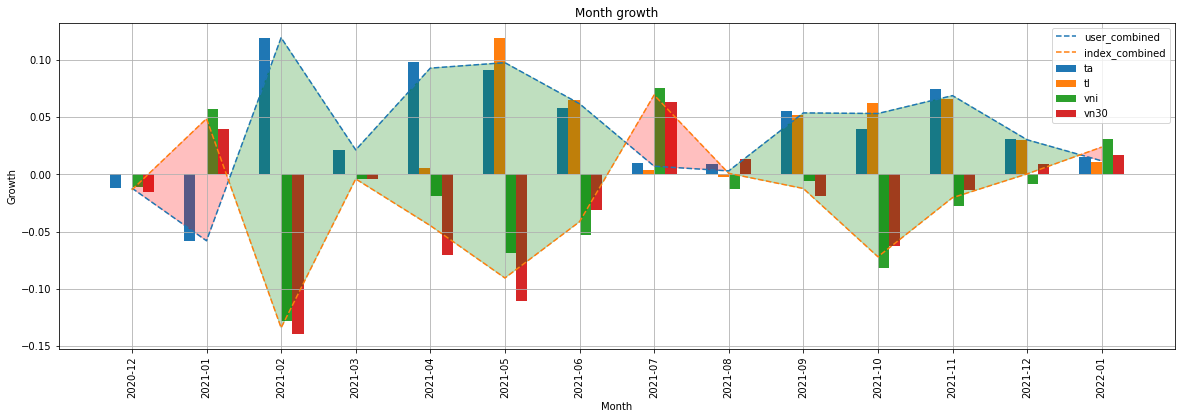

In [22]:
plot_growth(monthly_df, "Month")


## Quaterly


In [23]:
quaterly_df = get_period_df("Q", log_df)
quaterly_df.tail()


,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth
period,,,,,,
2021Q1,0.076729,0.000000,0.076729,-0.063339,-0.095588,-0.079255
2021Q2,0.267676,0.198343,0.272944,-0.158252,-0.246982,-0.202800
2021Q3,0.074897,0.053624,0.064147,0.052940,0.059140,0.056174
2021Q4,0.150810,0.166388,0.159242,-0.122400,-0.065112,-0.092652
2022Q1,0.014673,0.010489,0.011736,0.030559,0.017083,0.023748


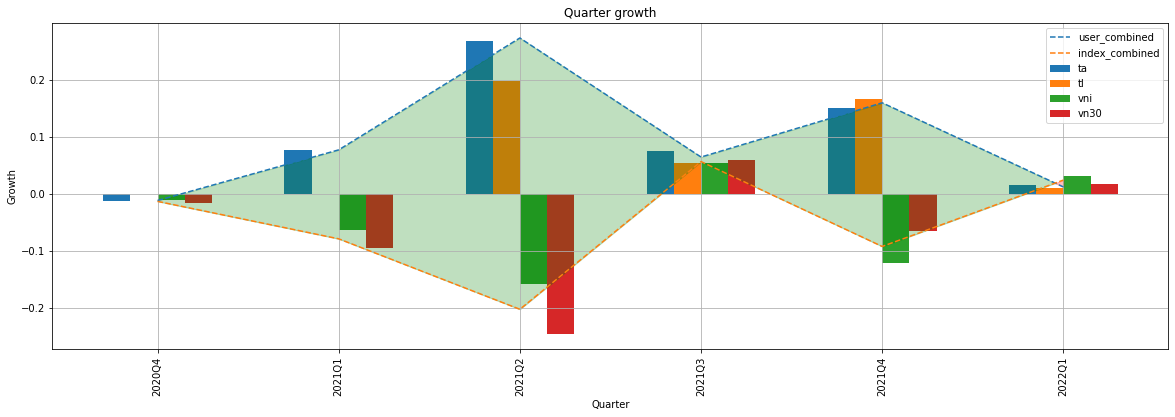

In [24]:
plot_growth(quaterly_df, "Quarter")
